# Project 5B: Flow Matching from Scratch!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [2]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Neural Network Resources

In this part, you will build and train a [UNet](https://arxiv.org/abs/1505.04597), which is more complex than the MLP you implemented in the NeRF project.  We provide all class definitions you may need (but feel free to add or modify them as necessary).  

Instead of asking ChatGPT to write everything for you, please consult the following resources when you get stuck — they will help you understand how and why things work under the hood.

- PyTorch Documentation — [`Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`ConvTranspose2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), and [`AvgPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
- PyTorch Documentation - [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), the dataset we gonna use, and [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html), the off-the-shell dataloader we can directly use.
- PyTorch [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train a classifier on CIFAR10 dataset. The structure of your training code will be very similar to this one.

# Part 1: Training a Single-step Denoising UNet


# Part 1.1: Implementing the UNet

## Implementing Simple and Composed Ops

In [3]:
import torch
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.gelu(self.bn(self.conv(x)))
        # ===== end of code ====


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.gelu(self.bn(self.conv(x)))
        # ===== end of code ====


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.convtranspose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.gelu(self.bn(self.convtranspose(x)))
        # ===== end of code ====


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        # ===== your code here! ====
        self.pool = nn.AvgPool2d(kernel_size = 7)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.gelu((self.pool(x)))
        # ===== end of code ====


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.convtranspose = nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 7, stride = 7, padding = 0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.gelu(self.bn(self.convtranspose(x)))
        # ===== end of code ====


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        # ===== end of code ====


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.downconv = DownConv(in_channels, out_channels)
        self.block = ConvBlock(out_channels, out_channels)

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        x = self.downconv(x)
        x = self.block(x)
        return x
        # ===== end of code ====


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.upconv = UpConv(in_channels, out_channels)
        self.block = ConvBlock(out_channels, out_channels)

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        x = self.upconv(x)
        x = self.block(x)
        return x
        # ===== end of code ====

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        D = num_hiddens
        self.down1 = ConvBlock(1, D)
        self.down2 = DownBlock(D, D)
        self.down3 = DownBlock(D, 2 * D)

        self.flatten = Flatten()
        self.unflatten = Unflatten(2 * D)

        self.up1 = UpBlock(4 * D, D)
        self.up2 = UpBlock(2 * D, D)

        self.conv = ConvBlock(2 * D, D)
        self.finalconv = nn.Conv2d(D, 1, kernel_size = 3, stride = 1, padding = 1)

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)

        flatten = self.flatten(d3)
        unflatten = self.unflatten(flatten)

        up1 = self.up1(torch.cat([unflatten, d3], dim = 1))
        up2 = self.up2(torch.cat([up1, d2], dim = 1))

        out1 = self.conv(torch.cat([up2, d1], dim = 1))
        out2 = self.finalconv(out1)

        return out2

        # ===== end of code ====

# Part 1.2: Using the UNet to Train a Denoiser

In [5]:
# Visualize images at different noisy level
# ===== your code here! ====
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]


img = next(iter(train_loader))[0]

plt.figure(figsize=(14, 2))
for i, sigma in enumerate(sigmas):
    noisy = img + sigma * torch.randn_like(img)
    noisy = torch.clamp(noisy, 0.0, 1.0)

    plt.subplot(1, len(sigmas), i + 1)
    plt.imshow(noisy[0, 0].cpu(), cmap="gray")
    plt.title(f"σ = {sigma}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ===== end of code ====

NameError: name 'train_loader' is not defined

## Part 1.2.1: Training

For this part, we provide some structure code for training. It is very basic, so feel free to change them or add your code. In later section we won't provide any training or visualization structure code.

In [6]:
device = torch.device('cuda')

# Set your hyperparameters
# ===== your code here! ====
batch_size = 256
learning_rate = 1e-4
noise_level = 0.5
hidden_dim = 128
num_epochs = 5
# ===== end of code ====

In [7]:
# Define your datasets and dataloaders
# ===== your code here! ====
train_dataset = MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

# ===== end of code ====

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


In [10]:
# Define your model, optimizer, and loss
# ===== your code here! ====
model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# ===== end of code ====

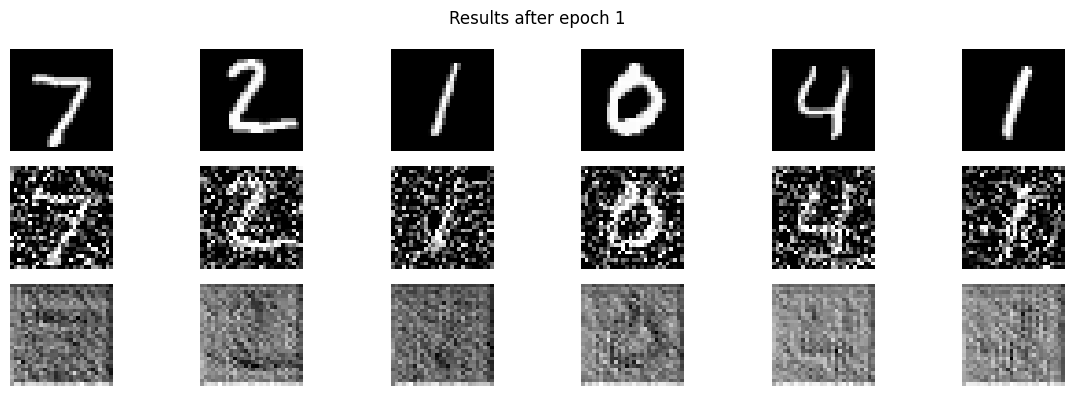

100%|██████████| 235/235 [01:30<00:00,  2.61it/s]


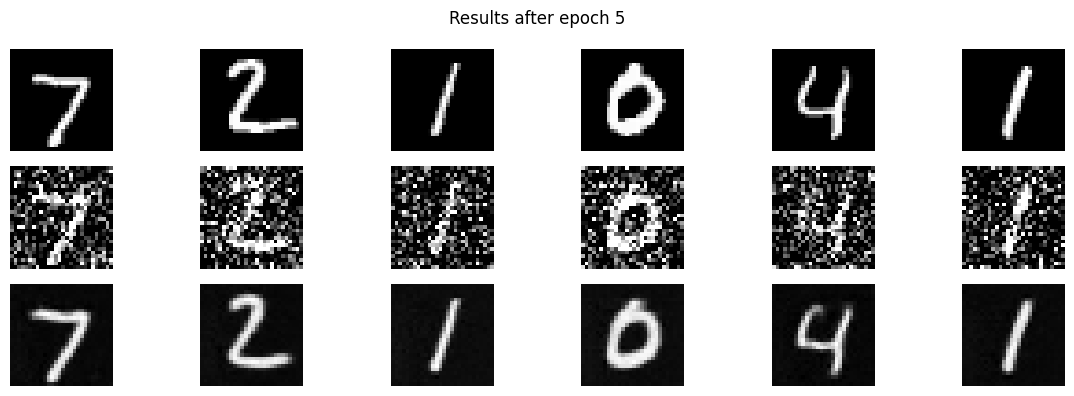

100%|██████████| 235/235 [01:30<00:00,  2.60it/s]


In [16]:
# The training loops
train_losses = []
for epoch in range(num_epochs):
    if epoch in [0,4]:
      model.eval()
      with torch.no_grad():
        test_images, _ = next(iter(test_loader))
        test_images = test_images[:6].to(device)
        sigma = 0.5
        noisy = torch.clamp(test_images + sigma * torch.randn_like(test_images), 0.0, 1.0)
        denoised = model(noisy)
      plt.figure(figsize=(12, 4))
      for i in range(6):
          # clean
          plt.subplot(3, 6, i + 1)
          plt.imshow(test_images[i, 0].cpu(), cmap="gray")
          plt.axis("off")
          if i == 0:
              plt.ylabel("Clean")

          # noisy
          plt.subplot(3, 6, 6 + i + 1)
          plt.imshow(noisy[i, 0].cpu(), cmap="gray")
          plt.axis("off")
          if i == 0:
              plt.ylabel("Noisy (σ=0.5)")

          # denoised
          plt.subplot(3, 6, 12 + i + 1)
          plt.imshow(denoised[i, 0].cpu(), cmap="gray")
          plt.axis("off")
          if i == 0:
              plt.ylabel(f"Denoised (epoch {epoch+1})")

      plt.suptitle(f"Results after epoch {epoch+1}")
      plt.tight_layout()
      plt.show()

      model.train()
    for i, (images, _) in enumerate(tqdm(train_loader)):

        # ===== your code here! ====
        images = images.to(device)

        noise = noise_level * torch.randn_like(images)
        noisy_images = torch.clamp(images + noise, 0.0, 1.0)

        outputs = model(noisy_images)

        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

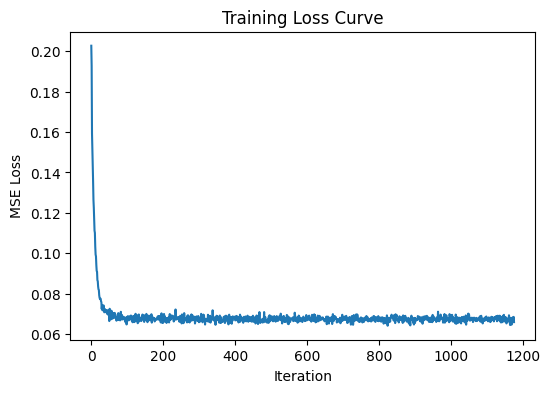

In [14]:
# Visualize your training curve
# ===== your code here! ====
plt.figure(figsize=(6,4))
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.show()
# ===== end of code ====

## Part 1.2.2: Out-of-Distribution Testing

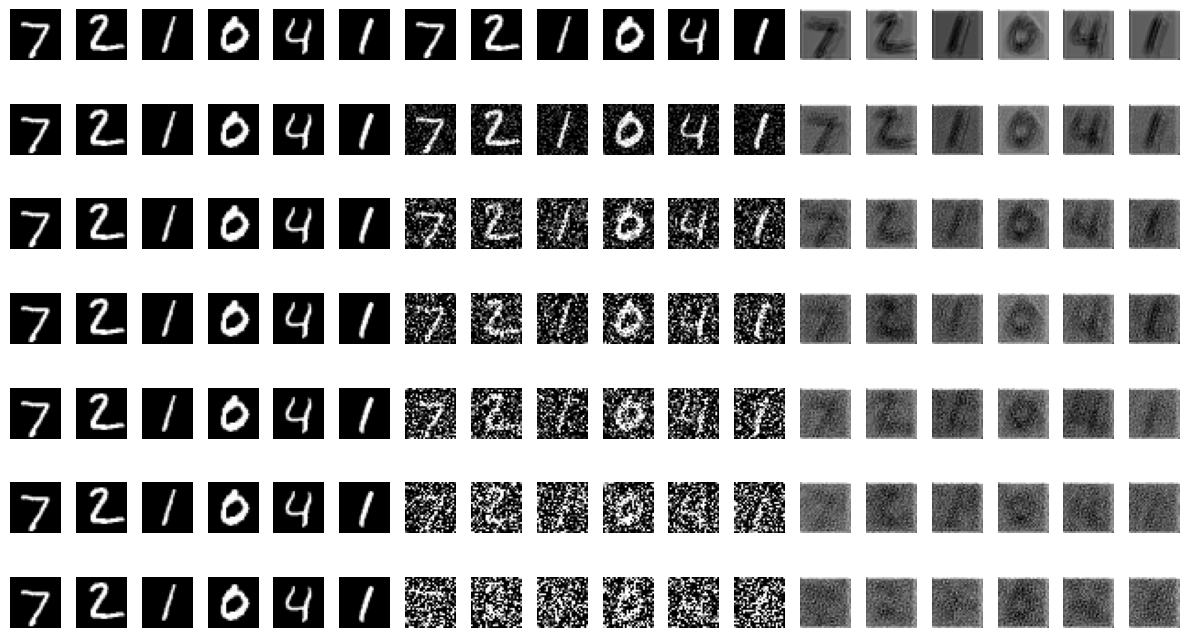

In [11]:
# Visualize OOD testing
# ===== your code here! ====
model.eval()

ood_sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

test_images, _ = next(iter(test_loader))
test_images = test_images[:6].to(device)

plt.figure(figsize=(12, 1 * len(ood_sigmas)))
with torch.no_grad():
    for row, sigma in enumerate(ood_sigmas):

        noise = sigma * torch.randn_like(test_images)
        noisy = torch.clamp(test_images + noise, 0.0, 1.0)

        denoised = model(noisy)

        for i in range(6):

            plt.subplot(len(ood_sigmas), 18, row * 18 + i + 1)
            plt.imshow(test_images[i, 0].cpu(), cmap='gray')
            plt.axis("off")
            if i == 0:
                plt.ylabel(f"σ={sigma}", fontsize=12)

            plt.subplot(len(ood_sigmas), 18, row * 18 + 6 + i + 1)
            plt.imshow(noisy[i, 0].cpu(), cmap='gray')
            plt.axis("off")

            plt.subplot(len(ood_sigmas), 18, row * 18 + 12 + i + 1)
            plt.imshow(denoised[i, 0].cpu(), cmap='gray')
            plt.axis("off")

plt.tight_layout()
plt.show()

# ===== end of code ====

## Part 1.2.3 Denoising Pure Noise

In [8]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


# ===== end of code ====

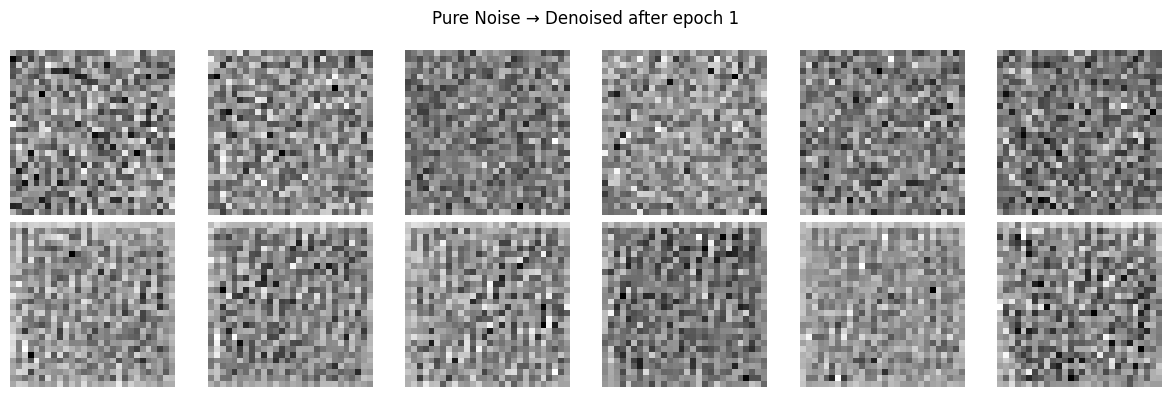

100%|██████████| 235/235 [01:34<00:00,  2.50it/s]


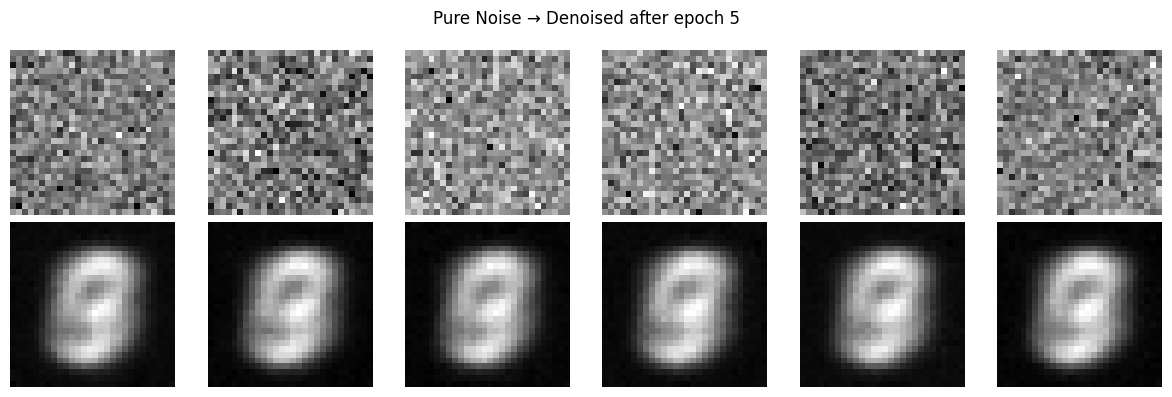

100%|██████████| 235/235 [01:33<00:00,  2.51it/s]


In [9]:
# The training loops
train_losses = []
for epoch in range(num_epochs):
    if epoch in [0, 4]:
        model.eval()
        with torch.no_grad():
            noise = torch.randn(6, 1, 28, 28).to(device)
            denoised = model(noise)

        plt.figure(figsize=(12, 4))
        for i in range(6):
            plt.subplot(2, 6, i + 1)
            plt.imshow(noise[i, 0].cpu(), cmap="gray")
            plt.axis("off")
            if i == 0:
                plt.ylabel("Pure Noise")

            plt.subplot(2, 6, 6 + i + 1)
            plt.imshow(denoised[i, 0].cpu(), cmap="gray")
            plt.axis("off")
            if i == 0:
                plt.ylabel(f"Denoised (epoch {epoch+1})")

        plt.suptitle(f"Pure Noise → Denoised after epoch {epoch+1}")
        plt.tight_layout()
        plt.show()

        model.train()
    for i, (images, _) in enumerate(tqdm(train_loader)):

        # ===== your code here! ====
        images = images.to(device)

        noise = torch.randn_like(images)

        outputs = model(noise)

        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

# Part 2: Flow Matching

# Part 2.1: Implementing a Time-conditioned UNet

In [34]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.l1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.l2 = nn.Linear(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.l2(self.gelu(self.l1(x)))
        # ===== end of code ====


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        D = num_hiddens
        self.down1 = ConvBlock(1, D)
        self.down2 = DownBlock(D, D)
        self.down3 = DownBlock(D, 2 * D)

        self.flatten = Flatten()
        self.unflatten = Unflatten(2 * D)

        self.up1 = UpBlock(4 * D, D)
        self.up2 = UpBlock(2 * D, D)

        self.conv = ConvBlock(2 * D, D)
        self.finalconv = nn.Conv2d(D, 1, kernel_size = 3, stride = 1, padding = 1)

        self.fc1 = FCBlock(1, 2 * D)
        self.fc2 = FCBlock(1, D)

        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        t = t.unsqueeze(1)
        fc1 = self.fc1(t)
        fc2 = self.fc2(t)


        fc1 = fc1.view(fc1.shape[0], fc1.shape[1], 1, 1)
        fc2 = fc2.view(fc2.shape[0], fc2.shape[1], 1, 1)

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)

        flatten = self.flatten(d3)
        unflatten = self.unflatten(flatten)

        unflatten = unflatten * fc1

        up1 = self.up1(torch.cat([unflatten, d3], dim = 1))
        up1 = up1 * fc2

        up2 = self.up2(torch.cat([up1, d2], dim = 1))

        out1 = self.conv(torch.cat([up2, d1], dim = 1))
        out2 = self.finalconv(out1)

        return out2
        # ===== end of code ====
        raise NotImplementedError()

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [35]:
def time_fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====
    N = x_1.shape[0]
    device = x_1.device

    x_0 = torch.randn_like(x_1)

    t = torch.rand(N, device = device)

    t_view = t.view(N, 1, 1, 1)

    x_t = (1.0 - t_view) * x_0 + t_view * x_1

    v_target = x_1 - x_0

    v_pred = unet(x_t, t)

    loss = nn.MSELoss()(v_pred, v_target)

    return loss

    # ===== end of code ====

In [36]:
@torch.inference_mode()
def time_fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # ===== your code here! ====
    torch.manual_seed(seed)

    H, W = img_wh
    device = next(unet.parameters()).device

    x = torch.randn(1, 1, H, W, device = device)

    dt = 1.0 / num_ts
    t = 0.0

    for i in range(num_ts):
      t_batch = torch.full((1,), t, device = device)
      pred = unet(x, t_batch)
      x = x + dt * pred
      t += dt

    return x
    # ===== end of code ====

In [37]:
class TimeConditionalFM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return time_fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return time_fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


# Part 2.2: Training the Time-conditioned UNet

100%|██████████| 235/235 [00:39<00:00,  5.94it/s]


Epoch 1/10, loss = 0.1455


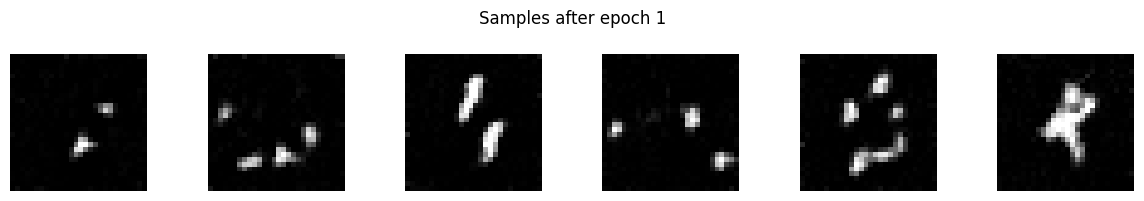

100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 2/10, loss = 0.1248


100%|██████████| 235/235 [00:39<00:00,  5.94it/s]


Epoch 3/10, loss = 0.1195


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 4/10, loss = 0.1187


100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Epoch 5/10, loss = 0.1037


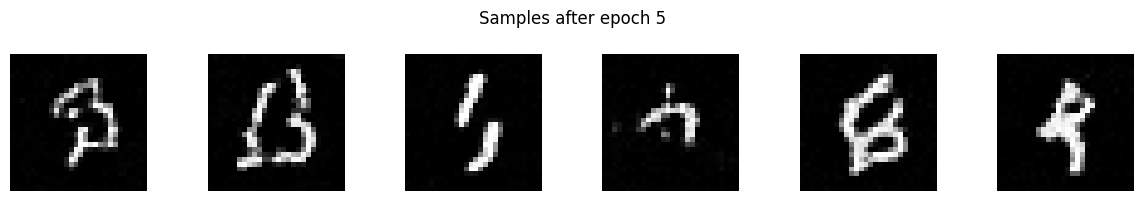

100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


Epoch 6/10, loss = 0.1029


100%|██████████| 235/235 [00:39<00:00,  5.90it/s]


Epoch 7/10, loss = 0.1041


100%|██████████| 235/235 [00:39<00:00,  5.92it/s]


Epoch 8/10, loss = 0.1023


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 9/10, loss = 0.0962


100%|██████████| 235/235 [00:40<00:00,  5.86it/s]


Epoch 10/10, loss = 0.0964


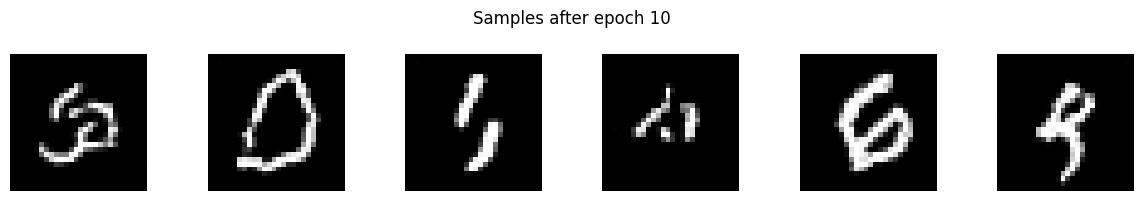

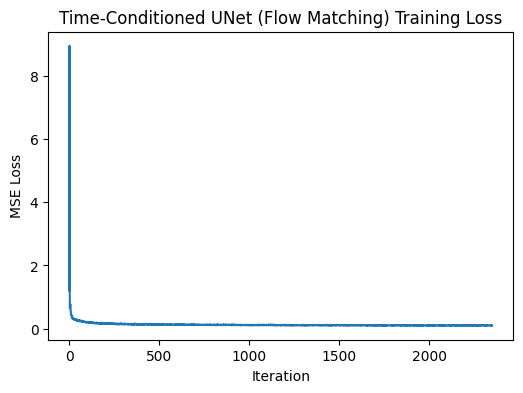

In [40]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====
model = TimeConditionalUNet(
    in_channels=1,
    num_classes=1,
    num_hiddens=64,
).to(device)

num_epochs = 10
num_ts = 50

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

gamma = 0.1 ** (1.0 / num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=gamma
)

train_losses = []

for epoch in range(num_epochs):
    model.train()

    for images, _ in tqdm(train_loader):
        images = images.to(device)

        optimizer.zero_grad()

        loss = time_fm_forward(model, images, num_ts)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, loss = {loss.item():.4f}")

    if epoch + 1 in [1, 5, 10]:
        model.eval()

        samples = []
        for seed in range(6):
            x = time_fm_sample(
                unet=model,
                img_wh=(28, 28),
                num_ts=num_ts,
                seed=seed
            )
            samples.append(x)

        samples = torch.cat(samples, dim=0)
        samples = torch.clamp(samples, 0.0, 1.0)

        plt.figure(figsize=(12, 2))
        for i in range(6):
            plt.subplot(1, 6, i + 1)
            plt.imshow(samples[i, 0].cpu(), cmap="gray")
            plt.axis("off")

        plt.suptitle(f"Samples after epoch {epoch+1}")
        plt.tight_layout()
        plt.show()

# ---- Training loss curve ----
plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Time-Conditioned UNet (Flow Matching) Training Loss")
plt.show()
# ===== end of code ====

# Part 2.3: Sampling from the Time-conditioned UNet

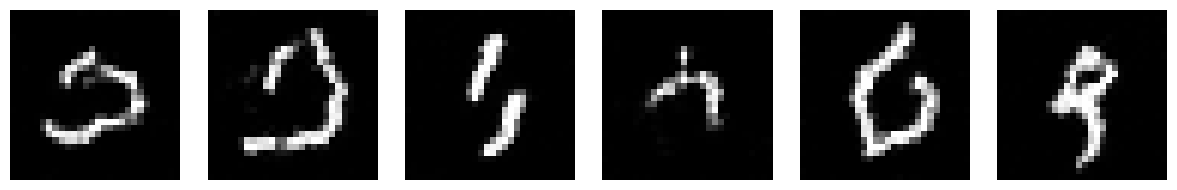

In [39]:
# Sampling from the UNet
# ===== your code here! ====
samples = []

for seed in range(6):
    x = time_fm_sample(
        unet=model,
        img_wh=(28, 28),
        num_ts=50,
        seed=seed
    )
    samples.append(x)

samples = torch.cat(samples, dim=0)
samples = torch.clamp(samples, 0.0, 1.0)

plt.figure(figsize=(12, 2))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(samples[i, 0].cpu(), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()
# ===== end of code ====

# Part 2.4: Implementing a Class-conditioned UNet

In [57]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        D = num_hiddens
        self.down1 = ConvBlock(1, D)
        self.down2 = DownBlock(D, D)
        self.down3 = DownBlock(D, 2 * D)

        self.flatten = Flatten()
        self.unflatten = Unflatten(2 * D)

        self.up1 = UpBlock(4 * D, D)
        self.up2 = UpBlock(2 * D, D)

        self.conv = ConvBlock(2 * D, D)
        self.finalconv = nn.Conv2d(D, 1, kernel_size = 3, stride = 1, padding = 1)

        self.fc1_t = FCBlock(1, 2 * D)
        self.fc2_t = FCBlock(1, D)
        self.fc1_c  = FCBlock(num_classes, 2 * D)
        self.fc2_c = FCBlock(num_classes, D)
        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        t = t.unsqueeze(1)
        fc1 = self.fc1_t(t)
        fc2 = self.fc2_t(t)

        c_onehot = torch.zeros(c.shape[0], 10, device=device)
        c_onehot.scatter_(1, c.unsqueeze(1), 1.0)

        if mask is not None:
          mask = mask.unsqueeze(1)
          c_onehot = c_onehot * mask

        c1 = self.fc1_c(c_onehot)
        c2 = self.fc2_c(c_onehot)

        fc1 = fc1.unsqueeze(-1).unsqueeze(-1)
        fc2 = fc2.unsqueeze(-1).unsqueeze(-1)
        c1 = c1.unsqueeze(-1).unsqueeze(-1)
        c2 = c2.unsqueeze(-1).unsqueeze(-1)


        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)

        flatten = self.flatten(d3)
        unflatten = self.unflatten(flatten)

        unflatten = c1 * unflatten + fc1

        up1 = self.up1(torch.cat([unflatten, d3], dim = 1))
        up1 = c2 * up1 + fc2

        up2 = self.up2(torch.cat([up1, d2], dim = 1))

        out1 = self.conv(torch.cat([up2, d1], dim = 1))
        out2 = self.finalconv(out1)

        return out2

        # ===== end of code ====

In [58]:
def class_fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====
    N = x_1.shape[0]
    device = x_1.device

    x_0 = torch.randn_like(x_1)

    t = torch.rand(N, device = device)

    t_view = t.view(N, 1, 1, 1)

    x_t = (1.0 - t_view) * x_0 + t_view * x_1

    v_target = x_1 - x_0

    mask = (torch.rand(N, device = device) > p_uncond).float()

    v_pred = unet(x_t, c, t, mask)

    loss = nn.MSELoss()(v_pred, v_target)

    return loss

    # ===== end of code ====

In [59]:
@torch.inference_mode()
def class_fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # ===== your code here! ====
    torch.manual_seed(seed)

    H, W = img_wh
    device = next(unet.parameters()).device
    N = c.shape[0]

    x = torch.randn(N, 1, H, W, device=device)

    dt = 1.0 / num_ts
    t = 0.0

    for _ in range(num_ts):
        t_batch = torch.full((N,), t, device=device)

        v_uncond = unet(
            x,
            c,
            t_batch,
            mask=torch.zeros(N, device=device),
        )

        v_cond = unet(
            x,
            c,
            t_batch,
            mask=torch.ones(N, device=device),
        )

        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        x = x + dt * v
        t += dt

    return x
    # ===== end of code ====

In [60]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

# Part 2.5 Training the Class-conditioned UNet

100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Epoch 1/10, loss = 0.1380


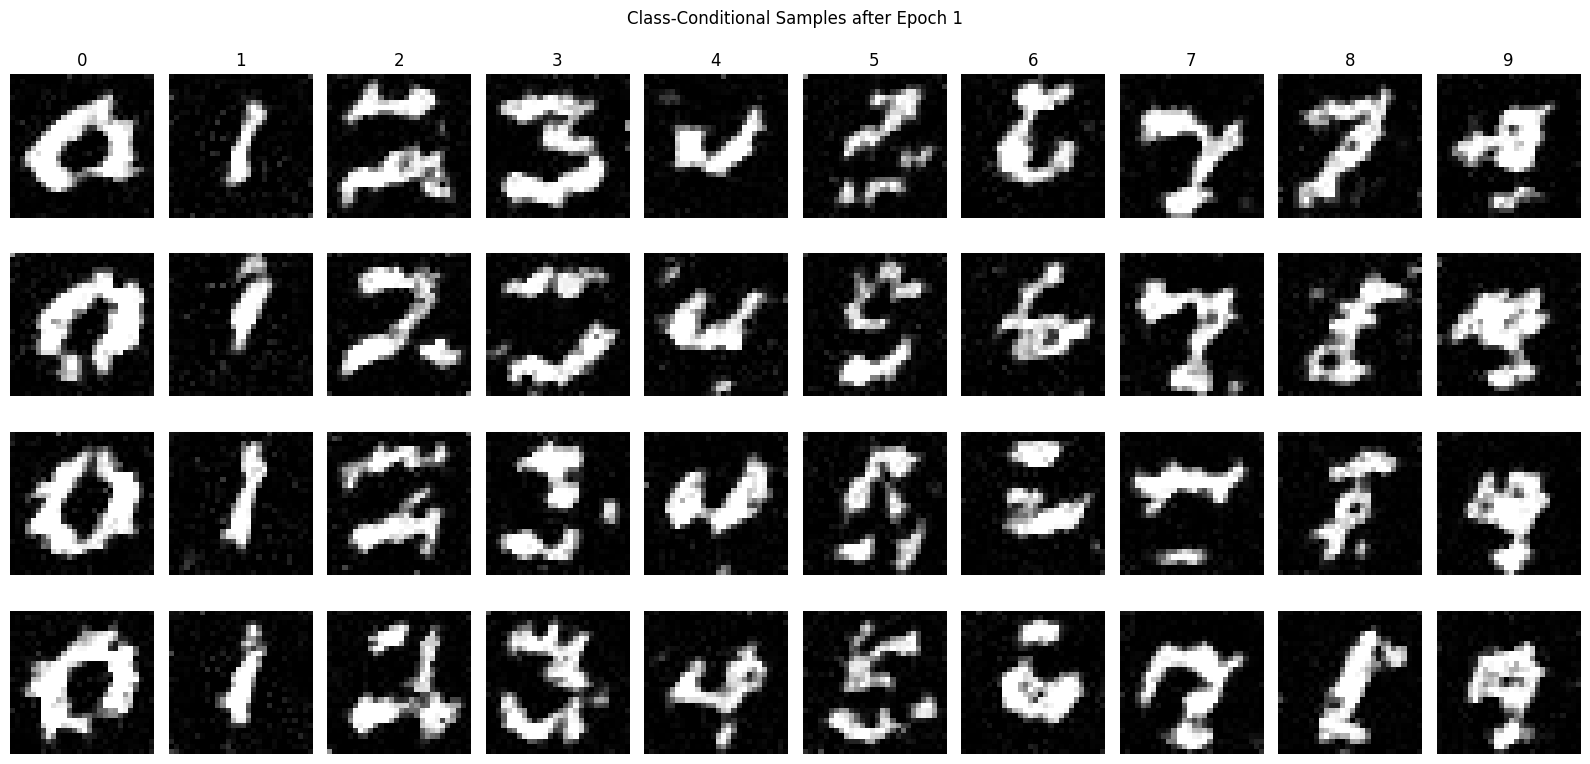

100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


Epoch 2/10, loss = 0.1258


100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Epoch 3/10, loss = 0.1295


100%|██████████| 235/235 [00:40<00:00,  5.85it/s]


Epoch 4/10, loss = 0.1117


100%|██████████| 235/235 [00:40<00:00,  5.85it/s]


Epoch 5/10, loss = 0.1133


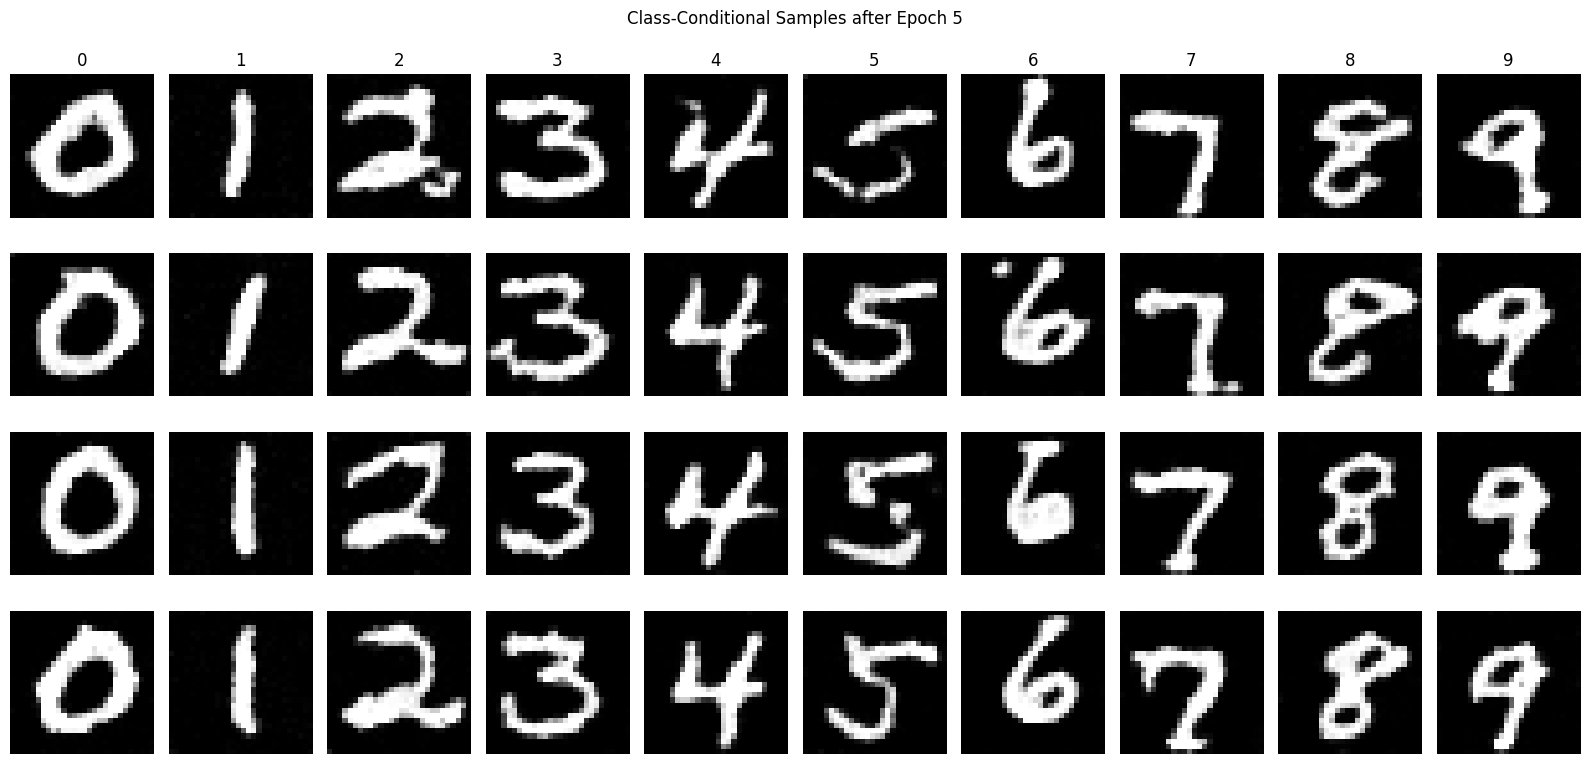

100%|██████████| 235/235 [00:40<00:00,  5.86it/s]


Epoch 6/10, loss = 0.1144


100%|██████████| 235/235 [00:40<00:00,  5.85it/s]


Epoch 7/10, loss = 0.1053


100%|██████████| 235/235 [00:40<00:00,  5.86it/s]


Epoch 8/10, loss = 0.0966


100%|██████████| 235/235 [00:40<00:00,  5.85it/s]


Epoch 9/10, loss = 0.1002


100%|██████████| 235/235 [00:40<00:00,  5.86it/s]


Epoch 10/10, loss = 0.0945


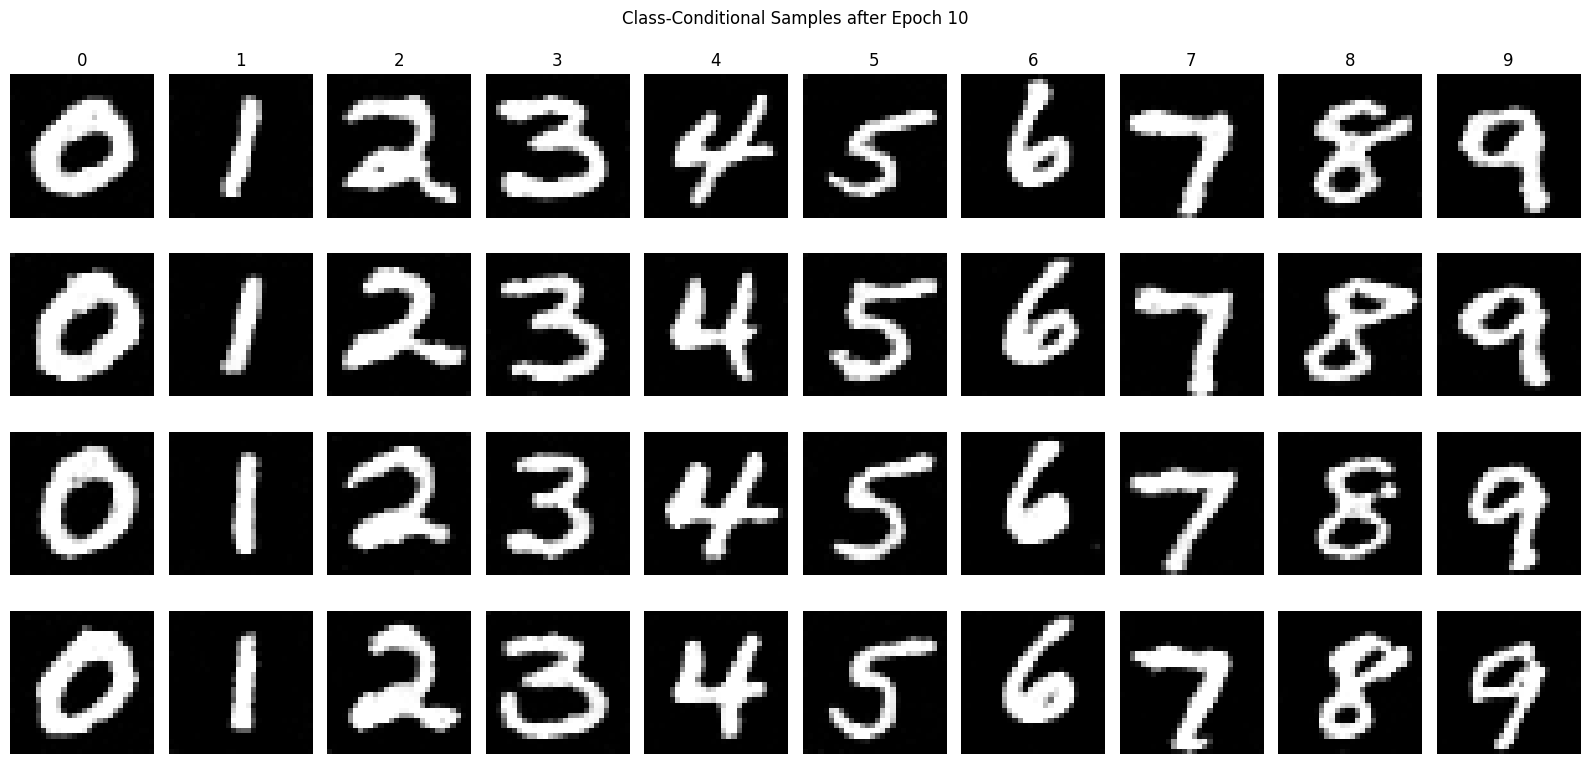

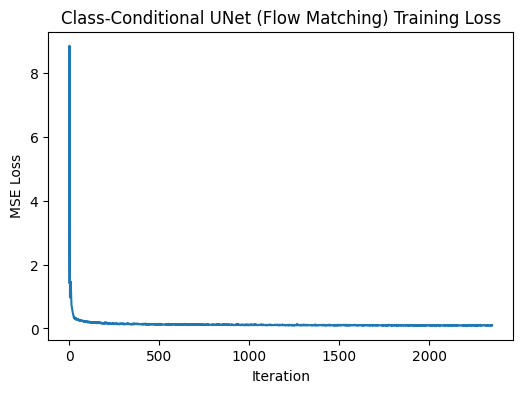

In [62]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

model = ClassConditionalUNet(
    in_channels=1,
    num_classes=10,
    num_hiddens=64,
).to(device)

num_epochs = 10
num_ts = 50
p_uncond = 0.1   # classifier-free guidance dropout prob

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

gamma = 0.1 ** (1.0 / num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=gamma
)

train_losses = []

for epoch in range(num_epochs):
    model.train()

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Class-conditional FM loss (Algorithm 3)
        loss = class_fm_forward(
            unet=model,
            x_1=images,
            c=labels,
            p_uncond=p_uncond,
            num_ts=num_ts,
        )

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, loss = {loss.item():.4f}")

    # ---- Sampling after epoch 1, 5, 10 ----
    if epoch + 1 in [1, 5, 10]:
      model.eval()

      c = torch.arange(10).repeat_interleave(4).to(device)

      samples = class_fm_sample(
          unet=model,
          c=c,
          img_wh=(28, 28),
          num_ts=num_ts,
          guidance_scale=5.0,
          seed=0,
      )

      samples = torch.clamp(samples, 0.0, 1.0)

      plt.figure(figsize=(16, 8))
      for digit in range(10):
          for k in range(4):
              idx = digit * 4 + k
              plt.subplot(4, 10, k * 10 + digit + 1)
              plt.imshow(samples[idx, 0].cpu(), cmap="gray")
              plt.axis("off")

              if k == 0:
                  plt.title(str(digit))

      plt.suptitle(f"Class-Conditional Samples after Epoch {epoch+1}")
      plt.tight_layout()
      plt.show()


# ---- Training loss curve ----
plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Class-Conditional UNet (Flow Matching) Training Loss")
plt.show()

# ===== end of code ====


# Part 2.6: Sampling from the Class-conditioned UNet

In [ ]:
# Sampling from the UNet
# ===== your code here! ====

# ===== end of code ====

100%|██████████| 235/235 [00:40<00:00,  5.86it/s]


Epoch 1/10, loss = 0.1568


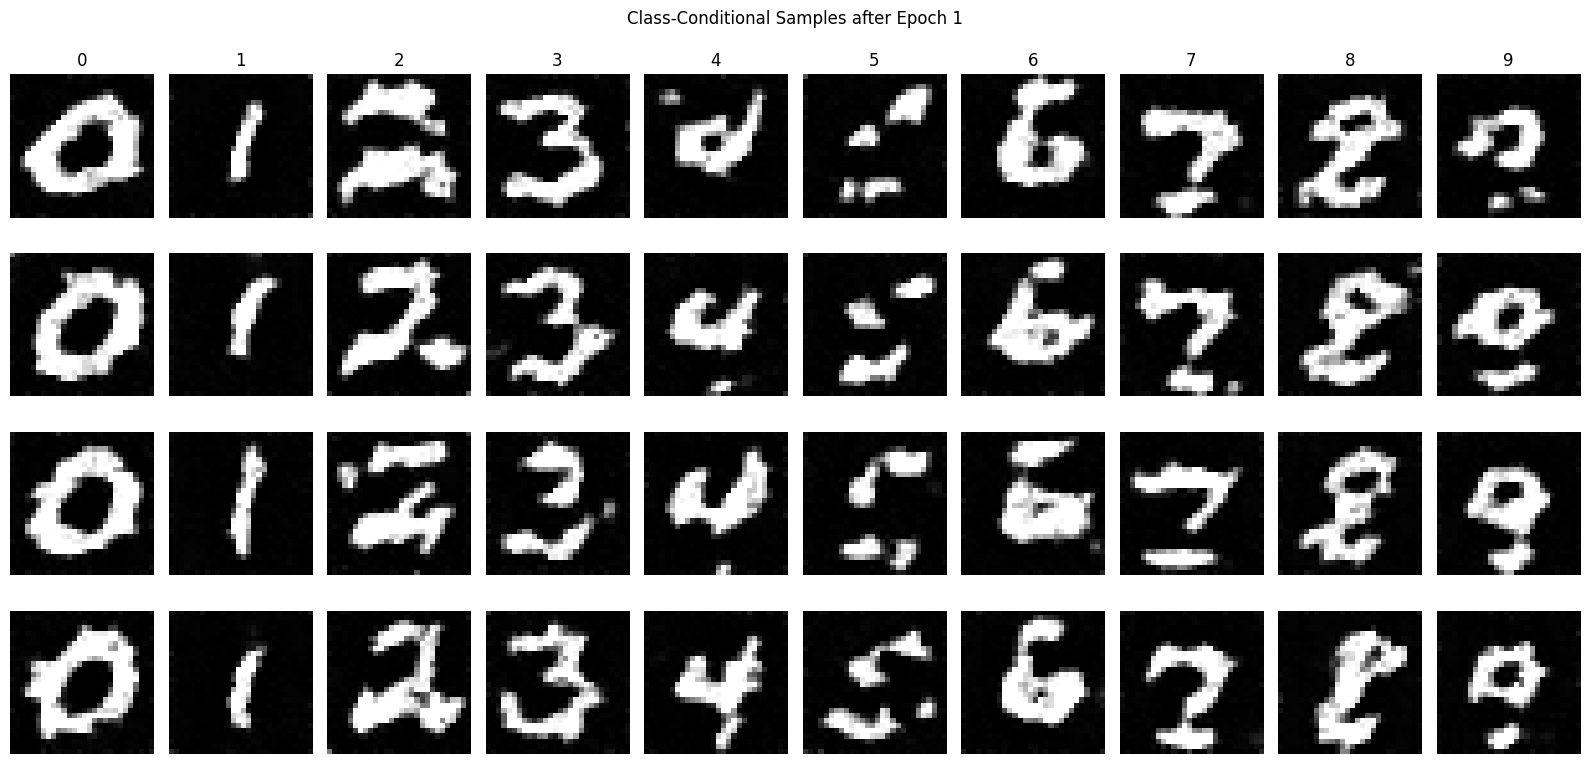

100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Epoch 2/10, loss = 0.1290


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 3/10, loss = 0.1193


100%|██████████| 235/235 [00:39<00:00,  5.90it/s]


Epoch 4/10, loss = 0.1161


100%|██████████| 235/235 [00:39<00:00,  5.90it/s]


Epoch 5/10, loss = 0.1138


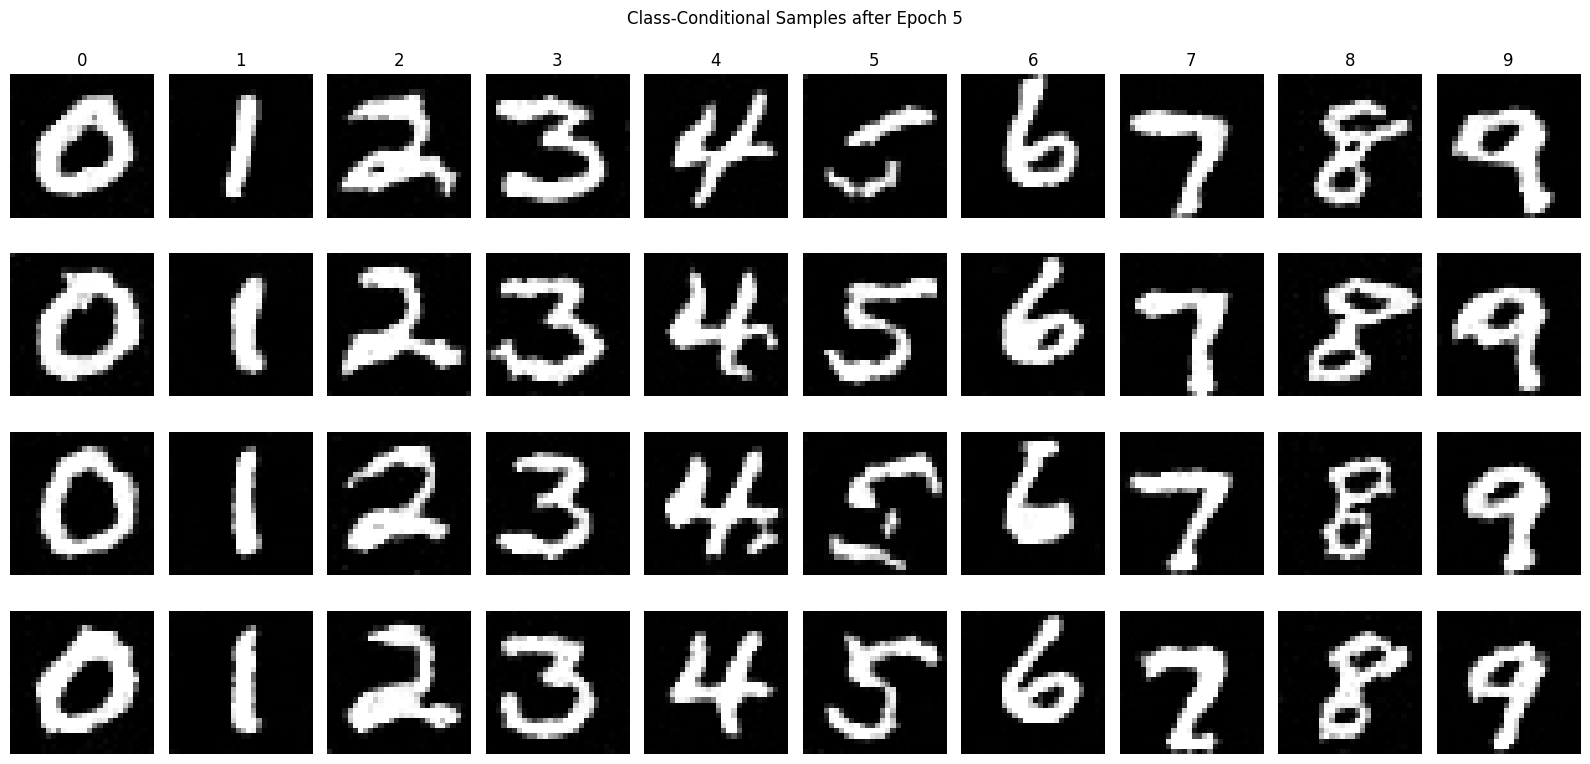

100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


Epoch 6/10, loss = 0.1168


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 7/10, loss = 0.1030


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 8/10, loss = 0.0958


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 9/10, loss = 0.0978


100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Epoch 10/10, loss = 0.0923


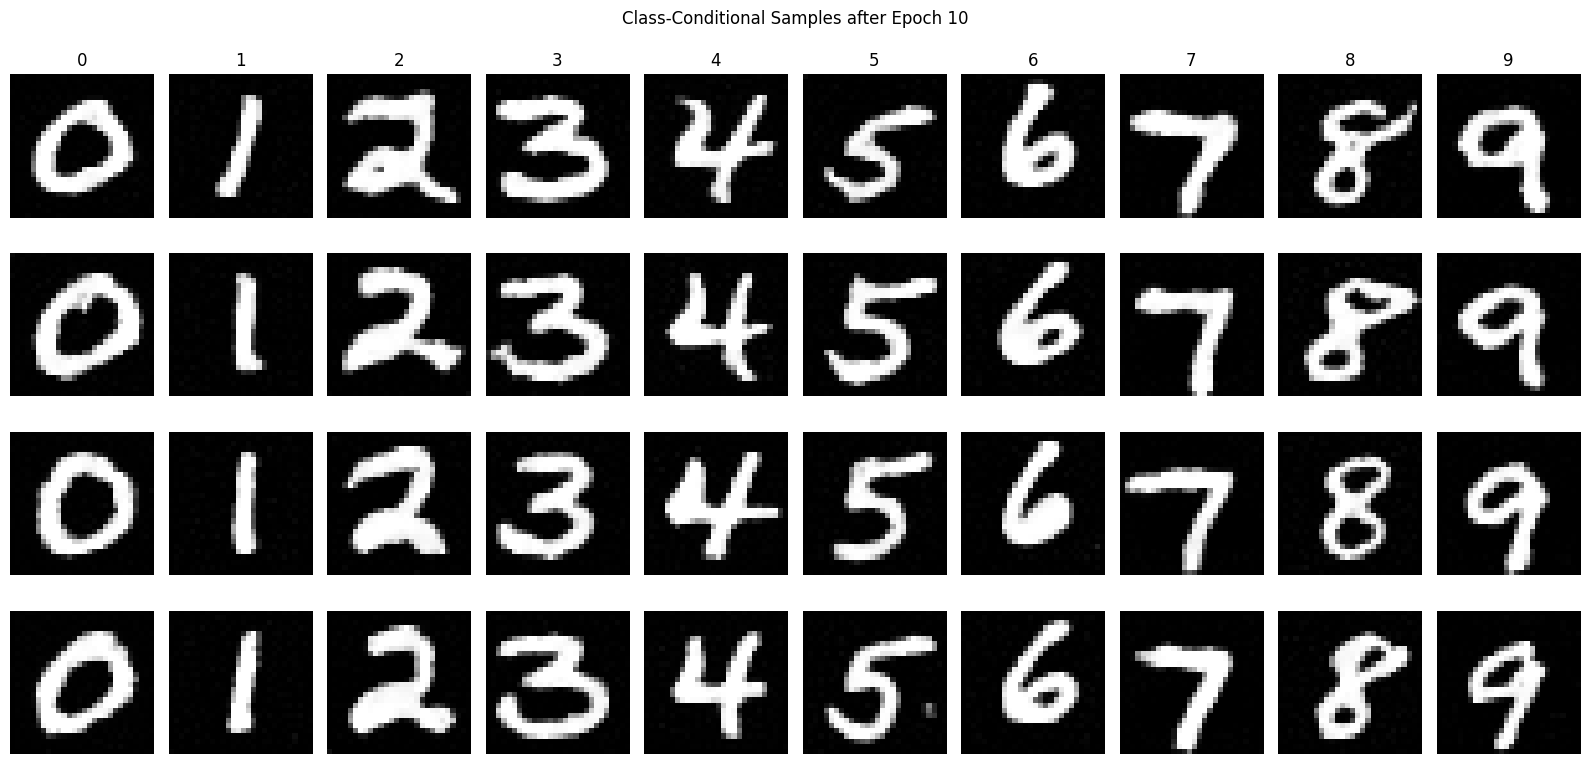

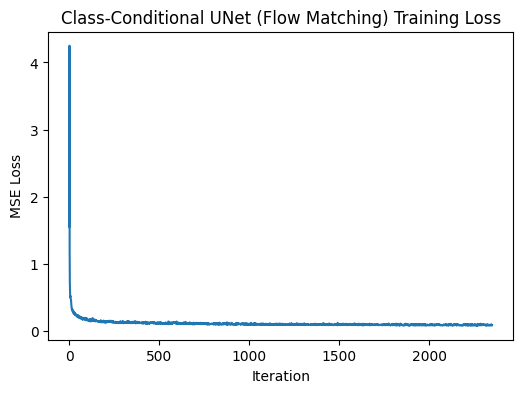

In [63]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

model = ClassConditionalUNet(
    in_channels=1,
    num_classes=10,
    num_hiddens=64,
).to(device)

num_epochs = 10
num_ts = 50
p_uncond = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

gamma = 0.1 ** (1.0 / num_epochs)

train_losses = []

for epoch in range(num_epochs):
    model.train()

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        loss = class_fm_forward(
            unet=model,
            x_1=images,
            c=labels,
            p_uncond=p_uncond,
            num_ts=num_ts,
        )

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, loss = {loss.item():.4f}")

    if epoch + 1 in [1, 5, 10]:
      model.eval()

      c = torch.arange(10).repeat_interleave(4).to(device)

      samples = class_fm_sample(
          unet=model,
          c=c,
          img_wh=(28, 28),
          num_ts=num_ts,
          guidance_scale=5.0,
          seed=0,
      )

      samples = torch.clamp(samples, 0.0, 1.0)

      plt.figure(figsize=(16, 8))
      for digit in range(10):
          for k in range(4):
              idx = digit * 4 + k
              plt.subplot(4, 10, k * 10 + digit + 1)
              plt.imshow(samples[idx, 0].cpu(), cmap="gray")
              plt.axis("off")

              if k == 0:
                  plt.title(str(digit))

      plt.suptitle(f"Class-Conditional Samples after Epoch {epoch+1}")
      plt.tight_layout()
      plt.show()


# ---- Training loss curve ----
plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Class-Conditional UNet (Flow Matching) Training Loss")
plt.show()

# ===== end of code ====
